# Variable Star Tutorial

In this tutorial, we will go over the types of variability `VSPEC` can model, along with options that are available to the user.

By default, `VSPEC` produces random variability. However, we will also go over some techniques to setup a custom-defined star.

In [2]:
import VSPEC
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np


## Overview

Recall that most of the work of `VSPEC` is done by the `ObservationModel` class. This class has an attribute `ObservationModel.star` which is a `Star` object. The `Star` class contains basic star parameters, sources of variability, and methods to produce spectra based on the variability.

## Spots

The longest-timescale source of variability contained in `VSPEC` are starspots. We model starspots as two-temperature circles -- an inner, low-T_{eff} umbra surrounded by slightly warmer panumbra annulus. They are represented by a `StarSpot` object. Every `Star` contains a `SpotCollection` -- an iterable of `StarSpot` with some extra methods, and a `SpotGenerator`, which creates and assigns parameters to new `StarSpot` objects.

In the config file, the parameters that control the spots are:

```
star_spot_initial_coverage = 0.2 # Fraction of the stellar surface to cover initially
star_spot_distribution = iso # Method to distribute spots: 'iso' or 'solar'
star_spot_mean_area = 500 # Mean spot area in Micro solar hemispheres (MSH)
star_spot_sigma_area = 0.2 # Log sigma of spot area in dex
star_spot_umbra_teff = 2500 # Teff of umbra
star_spot_penumbra_teff = 2900 # Teff of penumbra
star_spot_growth_rate = 0.52 # fractional spot growth rate in 1/day
star_spot_decay_rate = 10.8 # spot decay rate in MSH/day
star_spot_initial_area = 10.0 # initial spot area in MSH
star_spot_coverage = 0.0 # target equillibrium spot coverage
star_spot_warmup = 0.0 # time in days to simulate before observation (to approach equillibrium)
```

Let's make a quick `VSPEC` model with spots.

In [25]:
model = VSPEC.ObservationModel('spots.cfg')
model.build_star() # initialize the Star object
model.warm_up_star(spot_warmup_time=0*u.day) # initialize spots

Generated 39 mature spots


Now that we have generated some spots, let's look at them

In [26]:
for spot in model.star.spots.spots[:5]: # first five spots
    print(spot)

StarSpot with Teff = (2500 K,2900.0 K), area = 476 micro solar hemisphere, lat = -7.6 deg, lon = 142.8 deg
StarSpot with Teff = (2500 K,2900.0 K), area = 519 micro solar hemisphere, lat = -26.8 deg, lon = 61.3 deg
StarSpot with Teff = (2500 K,2900.0 K), area = 445 micro solar hemisphere, lat = -6.1 deg, lon = 139.1 deg
StarSpot with Teff = (2500 K,2900.0 K), area = 318 micro solar hemisphere, lat = 18.9 deg, lon = 266.4 deg
StarSpot with Teff = (2500 K,2900.0 K), area = 430 micro solar hemisphere, lat = 15.5 deg, lon = 210.1 deg


~20.0% of the surface is covered by spots


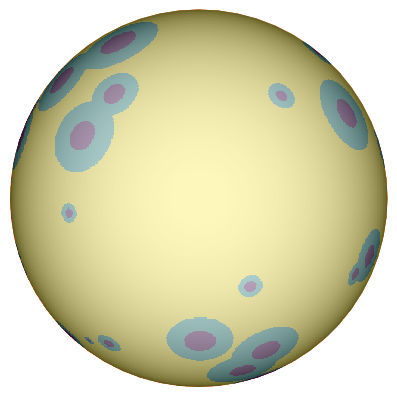

In [27]:
view_angle = {'lat':0*u.deg,'lon':0*u.deg}
model.star.plot_spots(view_angle,view_angle)
print(f'~{model.params.star_spot_initial_coverage*100}% of the surface is covered by spots')

Let's run the model and see what kind of variability we get.

In [28]:
model.bin_spectra()
model.build_planet()
model.build_spectra()

Binning Spectra:   0%|          | 0/12 [00:00<?, ?it/s]

Starting at phase 180.0 deg, observe for 10.0 d in 20 steps
Phases = [180.   198.95 217.89 236.84 255.79 274.74 293.68 312.63 331.58 350.53
   9.47  28.42  47.37  66.32  85.26 104.21 123.16 142.11 161.05 180.  ] deg


Build Planet:   0%|          | 0/20 [00:00<?, ?it/s]

Build Spectra:   0%|          | 0/480 [00:00<?, ?it/s]

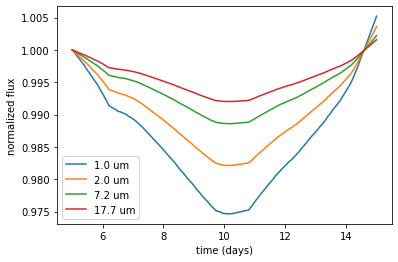

In [31]:
print(f'Data is stored in {model.dirs["all_model"]}')
data = VSPEC.PhaseAnalyzer(model.dirs['all_model'])
plt.plot(data.time.to(u.day),data.lightcurve('star',0,normalize=0),label=f'{data.wavelength[0]:.1f}')
plt.plot(data.time.to(u.day),data.lightcurve('star',35,normalize=0),label=f'{data.wavelength[35]:.1f}')
plt.plot(data.time.to(u.day),data.lightcurve('star',100,normalize=0),label=f'{data.wavelength[100]:.1f}')
plt.plot(data.time.to(u.day),data.lightcurve('star',145,normalize=0),label=f'{data.wavelength[145]:.1f}')
plt.xlabel('time (days)')
plt.ylabel('normalized flux')
plt.legend()

## Faculae

Faculae are magnetically-generated regions of the solar surface that usually appear as bright points near the limb. They are described as three-dimensional pores in the stellar surface with a hot, bright wall, and a cool, dark floor.
This complex structure is computationally expensive to model, and we ask the user to consider if modeling faculae is necessary to achieve their desired scientific result.

In the config file, faculae are described by these parameters:

```
star_fac_coverage = 0.001 # Target fractional coverage of the stellar surface (at equillibrium)
star_fac_mean_radius = 500 # Mean radius (km)
star_fac_HWMH_radius = 200 # Half-width-half-maximum of the lognormal radius distribution in the positive direction
star_fac_mean_timescale = 10 # mean lifetime (hours)
star_fac_HWMH_timescale = 4 # same as radius HWHM, but for lifetime
star_fac_distribution = iso # method to distribute faculae on sphere
star_fac_warmup = 30 # warmup time in hours to approach equillibrium
```

In [3]:
model = VSPEC.ObservationModel('faculae.cfg')
# model.build_star() # initialize the Star object
# model.warm_up_star(facula_warmup_time=3*u.day) # initialize faculae

In [45]:
print( f'This model contains {len(model.star.faculae.faculae)} faculae')

This model contains 158 faculae


Let's look closely at a single facule

In [46]:
fac = model.star.faculae.faculae[0]
print(f'Hot wall: {fac.Teff_wall}')
print(f'Cool Floor: {fac.Teff_floor}')
print(f'Radius: {fac.current_R:.0f}')

Hot wall: 3844.0 K
Cool Floor: 2694.0 K
Radius: 153 km


How does this 3D structure behave as it "transits" the stellar disk?

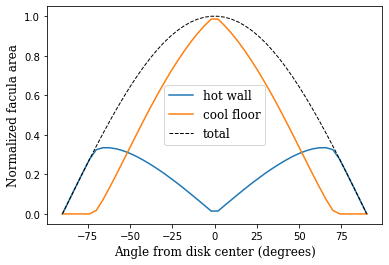

In [47]:
angles = np.linspace(-90,90,46)*u.deg
wall = []
floor = []
N = 101
for a in angles:
    dat = fac.fractional_effective_area(np.abs(a),N=N)
    wall.append(dat[fac.Teff_wall].value*np.cos(a))
    floor.append(dat[fac.Teff_floor].value*np.cos(a))
wall = np.array(wall)
floor = np.array(floor)
plt.plot(angles,wall,label='hot wall')
plt.plot(angles,floor,label='cool floor')
plt.plot(angles,wall+floor,label='total',c='k',ls='--',lw=1)
fontdict=dict(family='serif',size=12)
plt.xlabel('Angle from disk center (degrees)',fontdict=fontdict)
plt.ylabel('Normalized facula area',fontdict=fontdict)
plt.legend(prop=fontdict)
# plt.savefig('facula_area.png',dpi=120,facecolor='w')


This profile is calculated by a numerical integral. Let's see what kind of variability is produced by all the faculae in our model.

In [48]:
model.bin_spectra()
# model.build_planet()
model.build_spectra()

Binning Spectra:   0%|          | 0/17 [00:00<?, ?it/s]

Build Spectra:   0%|          | 0/480 [00:00<?, ?it/s]

Data is stored in faculae/Data/AllModelSpectraValues


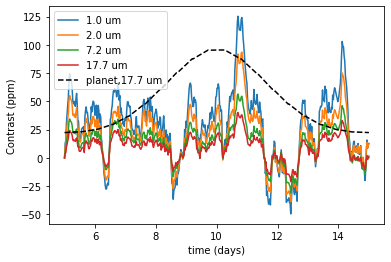

In [20]:
print(f'Data is stored in {model.dirs["all_model"]}')
data = VSPEC.PhaseAnalyzer(model.dirs['all_model'])
plt.plot(data.time.to(u.day),(data.lightcurve('star',0,normalize=0)-1)*1e6,label=f'{data.wavelength[0]:.1f}')
plt.plot(data.time.to(u.day),(data.lightcurve('star',35,normalize=0)-1)*1e6,label=f'{data.wavelength[35]:.1f}')
plt.plot(data.time.to(u.day),(data.lightcurve('star',100,normalize=0)-1)*1e6,label=f'{data.wavelength[100]:.1f}')
plt.plot(data.time.to(u.day),(data.lightcurve('star',145,normalize=0)-1)*1e6,label=f'{data.wavelength[145]:.1f}')
plt.plot(data.time.to(u.day),(data.lightcurve('thermal',145)/data.lightcurve('total',145))*1e6,label=f'planet,{data.wavelength[145]:.1f}',c='k',ls='--')
plt.xlabel('time (days)')
plt.ylabel('Contrast (ppm)')
plt.legend()

We see that even with this low (0.1%) faculae coverage, we see significant variation that can be similar magnitude to or much brighter than the planet (depending on the wavelength channel)

## Flares

Flares are short bursts of energy that peak quickly and decay over a timescale of hours. In `VSPEC`, flares are modeled using a blackbody spectrum in contrast to the stellar spectra used for the rest of our variability models. In the config file, flares are controlled by these parameters:
```
star_flare_group_prob = 0.25 # probability that any given flare is quickly followed by another flare
star_flare_mean_teff = 9000 # mean flare Teff
star_flare_sigma_teff = 500 # standard deviation of the gaussian Teff distribution
star_flare_mean_log_fwhm_days = -0.85 # mean log10 of the flare lightcurve FWHM in days
star_flare_sigma_log_fwhm_days = 0.3 # standard deviation of the log10 FWHM
star_flare_log_E_erg_min = 32.5 # minimum flare energy to consider
star_flare_log_E_erg_max = 34.5 # maximum flare energy to consider
star_flare_log_E_erg_Nsteps = 100 # number of flare energies to consider, logspaced between min and max
```

In [21]:
model = VSPEC.ObservationModel('flares.cfg')
model.build_star() # initialize the Star object
model.warm_up_star() # initialize flares

In [23]:
print( f'This observation contains {len(model.star.flares.flares)} flares')

This model contains 9 flares


Let's look at a single flare

Temperature: 9117.0 K
Energy: 6.15e+32 erg
tpeak: 1.1 d
fwhm: 1.6 h


[Text(0.5, 0, 'time (days)'), Text(0, 0.5, 'area of flare blackbody (km2)')]

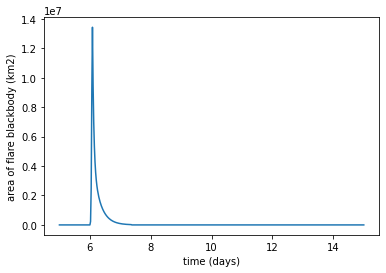

In [36]:
flare = model.star.flares.flares[0]
print(f'Temperature: {flare.Teff}')
print(f'Energy: {flare.energy.cgs:.2e}')
print(f'tpeak: {flare.tpeak.to(u.day):.1f}')
print(f'fwhm: {flare.fwhm.to(u.hr):.1f}')
plt.plot(data.time.to(u.day),flare.areacurve(data.time - data.time[0]))
plt.gca().set(xlabel='time (days)',ylabel='area of flare blackbody (km2)')

In the backend, the flare is treated as a surface of constant tempemperature. We use the total energy, FWHM, and Stefan-Boltzmann law to calculate the area at every time coordinate. This area curve is then easily translated into a spectroscopic lightcurve given a blackbody temperature.



In [37]:
model.bin_spectra()
model.build_planet()
model.build_spectra()

Binning Spectra:   0%|          | 0/3 [00:00<?, ?it/s]

Starting at phase 180.0 deg, observe for 10.0 d in 20 steps
Phases = [180.   198.95 217.89 236.84 255.79 274.74 293.68 312.63 331.58 350.53
   9.47  28.42  47.37  66.32  85.26 104.21 123.16 142.11 161.05 180.  ] deg


Build Planet:   0%|          | 0/20 [00:00<?, ?it/s]

Build Spectra:   0%|          | 0/480 [00:00<?, ?it/s]

Data is stored in flares/Data/AllModelSpectraValues


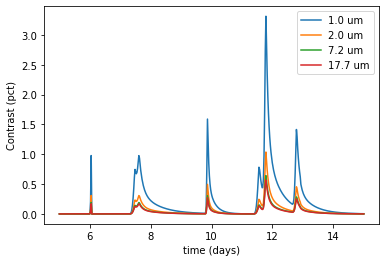

In [40]:
print(f'Data is stored in {model.dirs["all_model"]}')
data = VSPEC.PhaseAnalyzer(model.dirs['all_model'])
plt.plot(data.time.to(u.day),(data.lightcurve('star',0,normalize=0)-1)*100,label=f'{data.wavelength[0]:.1f}')
plt.plot(data.time.to(u.day),(data.lightcurve('star',35,normalize=0)-1)*100,label=f'{data.wavelength[35]:.1f}')
plt.plot(data.time.to(u.day),(data.lightcurve('star',100,normalize=0)-1)*100,label=f'{data.wavelength[100]:.1f}')
plt.plot(data.time.to(u.day),(data.lightcurve('star',145,normalize=0)-1)*100,label=f'{data.wavelength[145]:.1f}')
# plt.plot(data.time.to(u.day),(data.lightcurve('thermal',145)/data.lightcurve('total',145))*1e6,label=f'planet,{data.wavelength[145]:.1f}',c='k',ls='--')
plt.xlabel('time (days)')
plt.ylabel('Contrast (pct)')
plt.legend()